# **Assignment 5: Latent Linear Dynamical Systems**


Latent Linear Dynamical Systems are probabilistic models used to describe time series data where the observations are assumed to be noisy linear transformations of a lower-dimensional latent process that evolves linearly over time. The system is defined by:


\begin{align*}
    z_t &= A z_{t-1} + w_t,\quad w_t \sim \mathcal{N}(0, Q) \\
    x_t &= C z_t + v_t,\quad v_t \sim \mathcal{N}(0, R)
\end{align*}


Here, the variables are as follows:

* $ z_t \in \mathbb{R}^k $: latent (hidden) state at time $ t $
* $ x_t \in \mathbb{R}^d $: observed data at time $ t $
* $ A \in \mathbb{R}^{k \times k} $: state transition matrix
* $ C \in \mathbb{R}^{d \times k} $: observation matrix
* $ Q \in \mathbb{R}^{k \times k} $: process noise covariance
* $ R \in \mathbb{R}^{d \times d} $: observation noise covariance
* $ \mu_0, \Sigma_0 $: initial state mean and covariance:  $ z_0 \sim \mathcal{N}(\mu_0, \Sigma_0 ) $


In neuroscience applications, $x_t$ is typically neural activity at time $t$. The variable $z_t$ is a latent process that is driving this activity.

### Expectation-Maximization (EM) for LDS

The goal is to learn the parameters

\begin{align*}
\theta = \{A, C, Q, R, \mu_0, \Sigma_0\}
\end{align*}

from observed data $ \{x_t\}_{t=1}^T $, treating $ \{z_t\} $ as hidden variables. To do this, simply use the same trick that we used throughout the class; find $\theta$ that maximizes the likelihood $ p(x_{1:T} \mid \theta) $. However, this is intractable because of the latent states. The EM algorithm solves this by iteratively performing the following:

* E-step:  Compute the posterior expectations of latent states given a fixed $ \theta $.
* M-step: Maximize the expected complete-data log-likelihood with respect to parameters $ \theta $.


This week's handout on LDS has a description of both these steps. For this assignment however, you will only need to fill the part of the code that corresponds to the first part of the E step that is called the Kalman Filter. This filter is composed of two steps: a prediction step and an update step and allows us to estimate the hidden state $ z_t $ from noisy observations $ x_t $. Let us use the following notation:


* $ \hat{z}_{t|t-1} $: predicted state at time $ t $ given observations up to $ t-1 $
* $ \hat{z}_{t|t} $: updated state estimate after observing $ x_t $
* $ P_{t|t-1} $: predicted covariance
* $ P_{t|t} $: updated covariance
* $ K_t $: Kalman gain

##  The complete forward pass: Kalman Filter (that you will need to implement) is given by the following loop:

### For each $ t = 1, \ldots, T $:

### Prediction Step: returns predicted variables before observation at time t
\begin{align*}
    \hat{z}_{t|t-1} &= A \hat{z}_{t-1|t-1} \\
    P_{t|t-1} &= A P_{t-1|t-1} A^\top + Q
\end{align*}

### Update Step: returns filtered variables after observation at time t
\begin{align*}
    S_t &= C P_{t|t-1} C^\top + R  \quad \text{matrix to be inverted in the gain} \\
    K_t &= P_{t|t-1} C^\top  S_t^{-1} \quad \text{Kalman gain}\\
    I_t &= (x_t - C \hat{z}_{t|t-1}) \quad \text{Residual or Innovation} \\
    \hat{z}_{t|t} &= \hat{z}_{t|t-1} + K_t I_t \\
    P_{t|t} &= (I - K_t C) P_{t|t-1}
\end{align*}




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.cm import get_cmap
from sklearn.linear_model import Ridge
import seaborn as sns
from scipy.stats import zscore



sns.set_theme(style="ticks",
              palette="Set1",
              font_scale=2,
              rc={
              "axes.spines.right": False,
              "axes.spines.top": False,
          },
          )


### Data:

The data is available as numpy array file on moodle called `traces_4dir.npy`. These are calcium imaging activity from 300 neurons around the midbrain/hindbrain boundary of zerafish. The data was obtained using a 2P microscope while the fish was presented with whole field moving stimulus in 4 directions  0°, 90°, 180° and -90°. Fish use this information to estimate their movemement in the water and adapte their swim often by swiming in the stimulus motion direction (so opposite to their own ). This behavior is called the optomotor response. The area that was imaged has many sensory neurons that are tuned to the direction of the stimulus motion. Downstream motor neurons gather (decode) information from these sensory neurons to produce the desired motor action.

There are $24$ trials in this data. In each trial one direction of the stimulus was shown for almost 10 seconds which corredsponds 60 frames at 3Hz on the imaging side. Each trial will have a label: 1 for 0° motion, 2 for 90°  motion, 3 for 180°  motion and 4 for -90°  motion.

In [ ]:
############# THIS CELL LOADS THE DATA AND MAKES IT IN THE APPROPRIATE FORM FOR ANALYSIS ###############


# RUN THIS LINE IF YOU DOWLOADED THE DATA LOCALLY FROM MOODE
all_traces =  np.load('traces_4dir.npy')

print(all_traces.shape)
# OTHERWISE RUN CELL BELOW TO LOAD THE DATA


In [2]:
# OTHEWISE, FETCH THE DATA FROM DRIVE IF YOU ARE ON GOOGLE COLAB OR CONNECTED TO JUPYTER LAB

!pip install gdown
import gdown

def fecth_npy_from_drive_id(file_id, output_filename=None):
    url = f"https://drive.google.com/uc?id={file_id}"

    if output_filename is None:
        output_filename = "downloaded.npy"

    gdown.download(url, output_filename, quiet=False)

    return np.load(output_filename)

# stimulus and spike train files from link id (do not change the link ids)
traces_file = "1v5a2Hcpf614nfpWsomWooD57It6FL5sr"
all_traces = fecth_npy_from_drive_id(traces_file)



print(all_traces.shape)

Downloading...
From: https://drive.google.com/uc?id=1v5a2Hcpf614nfpWsomWooD57It6FL5sr
To: /content/downloaded.npy
100%|██████████| 3.44M/3.44M [00:00<00:00, 173MB/s]

(300, 1435)


In [3]:
#############  THIS CELL MAKES THE DATA IN THE CORRECT FORMAT FOR ANALYSIS, YOU DON'T NEED TO CHANGE ANYTHING - RUN THE CELL ###############


#### these are the stimuli codes that were shown to the fish:
stimulus_labels = np.array([4,3,2,1,4,1,2,3,1,4,2,3,2,1,3,4,1,4,2,3,1,2,3,4])

### the traces correspond to the full experiment, with pauses
## Let's make a list for trials when the stimulus was present instead


trial_duration = 60
num_trials = 24

x = all_traces.T
x_list = []

for k in range(num_trials):
    m = trial_duration*k
    x_list.append(zscore(x[m+trial_duration//2:m+trial_duration,:],axis = 0))


In [4]:
############# THIS IS A FUNCTION FOR PLOTTING, YOU DON'T NEED TO CHANGE IT BUT YOU WILL USE IT LATER - RUN THE CELL ###############

def plot_latents_by_stimulus(latent_list, stimuli):
    """

    Args:
        latent_list: list of (T, d) arrays, one per trial
        stimuli: list/array of integers, one per trial

    """
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
    assert len(latent_list) == len(stimuli), "Stimulus list must match number of trials"
    d = latent_list[0].shape[1]
    unique_stims = np.unique(stimuli)
    stim_to_color = {stim: colors[i] for i, stim in enumerate(unique_stims)}
    #stim_to_color = {stim: cmap(i) for i, stim in enumerate(unique_stims)}

    fig, axs = plt.subplots(d, 1, figsize=(10, 4 * d), sharex=True)

    if d == 1:
        axs = [axs]

    for trial_idx, (x, stim) in enumerate(zip(latent_list, stimuli)):
        T = x.shape[0]
        color = stim_to_color[stim]
        for dim in range(d):
            axs[dim].plot(np.arange(T), x[:, dim], color=color, alpha=0.9,linewidth = 2)

    for dim in range(d):
        axs[dim].set_ylabel(f"Latent {dim + 1}")
        axs[dim].set_title(f"Latent Dimension {dim + 1} Over Time")

    axs[-1].set_xlabel("Time")

    # Add legend only once
    handles = [plt.Line2D([], [], color=stim_to_color[s], label=f"Stim {s}") for s in unique_stims]
    axs[0].legend(handles=handles, title="Stimulus")

    plt.tight_layout()
    plt.show()


## Question 0

The function `fit_lds_em` below implements the EM algorithm to fit linear dynamical systems to data. All the steps are implemented already,
except the forward pass: kalman filter. The missing lines are indicated by dots. You simply need to fill those lines using the equations that were provided in
the description.



In [5]:

def fit_lds_em(data_list, d, num_iter=20):
    """
    This function fits LDS using EM.

    Args:
        data_list: list of (time, neurons) numpy arrays
        d: latent dimension
    Returns:
        A, C, Q_diag, R_diag: LDS parameters (Q and R are diagonal)
        latent_list: list of smoothed latent trajectories (time, d)
    """
    np.random.seed(0)
    n = data_list[0].shape[1]
    A = 0.99 * np.eye(d)
    C = np.random.randn(n, d)
    Q_diag = np.ones(d)
    R_diag = 0.1 * np.ones(n)

    def kalman_smoother(x, A, C, Q_diag, R_diag):
        T = x.shape[0]
        Q = np.diag(Q_diag)
        R = np.diag(R_diag)

        z_pred = np.zeros((T, d))
        P_pred = np.zeros((T, d, d))
        z_filt = np.zeros((T, d))
        P_filt = np.zeros((T, d, d))
        z_smooth = np.zeros((T, d))
        P_smooth = np.zeros((T, d, d))
        J = np.zeros((T - 1, d, d))

        P_pred[0] = np.eye(d)


        ########################## FORWARD PASS ##########################

        # This part implements the Kalman filter described above
        # including the prediction step (returns predeicted variables: z_pred and P_pred)
        # and the update step (returns filtered variables: z_filt and P_filt)

        # FILL THE MISSING LINES HERE:

        for t in range(T):
            if t > 0:
                ### prediction step
                z_pred[t] = A @ z_filt[t-1]    # prediction z_t|t-1
                P_pred[t] = A @ P_filt[t-1] @ A.T + Q # prediction P_t|t-1

            ### update step
            S = C @ P_pred[t] @ C.T + R  # matrix to be inverted in the gain
            K = P_pred[t] @ C.T @ np.linalg.inv(S)  # Kalman gain
            I = x[t] - C @ z_pred[t]   # residual or innovation
            z_filt[t] = z_pred[t] + K @ I  # filtered z_t|t
            P_filt[t] = P_pred[t] - K @ C @ P_pred[t] # filtered P_t|t

          # THE REST OF THE CODE DO NOT NEED TO BE CHANGED:

        ########################## BACKWARD PASS ##########################
        z_smooth[-1] = z_filt[-1]
        P_smooth[-1] = P_filt[-1]

        for t in reversed(range(T - 1)):
            J[t] = P_filt[t] @ A.T @ np.linalg.inv(P_pred[t + 1])
            z_smooth[t] = z_filt[t] + J[t] @ (z_smooth[t + 1] - z_pred[t + 1])
            P_smooth[t] = P_filt[t] + J[t] @ (P_smooth[t + 1] - P_pred[t + 1]) @ J[t].T

        return z_smooth, P_smooth

    for it in range(num_iter):
        EzzT = np.zeros((d, d))
        EzzT1 = np.zeros((d, d))
        EznzT = np.zeros((n, d))
        Exx = np.zeros(n)
        A_num = np.zeros((d, d))
        A_denom = np.zeros((d, d))
        total_T = 0
        latent_list = []

        for x in data_list:
            z_smooth, P_smooth = kalman_smoother(x, A, C, Q_diag, R_diag)
            latent_list.append(z_smooth)
            T = x.shape[0]
            total_T += T

            # E[x_t x_t^T] + P_t: shape (d, d)
            EzzT += np.einsum("ti,tj->ij", z_smooth, z_smooth) + P_smooth.sum(axis=0)
            EznzT += np.einsum("ti,tj->ij", x, z_smooth)
            Exx += np.einsum("ti,ti->i", x, x)

            A_num += np.einsum("ti,tj->ij", z_smooth[1:], z_smooth[:-1])
            A_denom += np.einsum("ti,tj->ij", z_smooth[:-1], z_smooth[:-1]) + P_smooth[:-1].sum(axis=0)

        # M-step
        A = A_num @ np.linalg.inv(A_denom)
        C = EznzT @ np.linalg.inv(EzzT)

        Q_resid = EzzT - A @ A_denom @ A.T
        Q_diag = np.clip(np.diag(Q_resid) / total_T, 1e-6, None)

        RC = C @ EzzT
        R_diag = (Exx - 2 * np.sum(C * EznzT, axis=1) + np.sum(C * RC, axis=1)) / total_T
        R_diag = np.clip(R_diag, 1e-6, None)

    return A, C, Q_diag, R_diag, latent_list



## Question 1

Since there are 4 types of stimul. we will fix the dimemsion of the latent variables to be $d = 4$

* Run the function fit_lds_em on the imaging data (this can take a couple of minutes: 1 min 40 sec. on google colab cpu) and plot the matrices $A$, $C$ and  $CC^\top$.
* Describe the structure of each of these matrices and give your intrepretation for each of them

#######

In the case of the first matrix, we can see a nearly diagonal matrix that suggests that each latent factor evolves mostly independently. This is common when latent dynamics are assumed to be simple or when latent features are relatively separable.

In the observation matrix, each row corresponds to a neuron, each column to a latent factor. It tells you how strongly each neuron is driven by each latent variable. The pattern structure shows that some neurons are strongly modulated by specific latent dimensions. On the other hand, the vertical patterns suggest that clusters of neurons may be responding similarly, possibly encoding the same stimulus features.

In the CCT matrix (covariance matrix of the data induced by the latent structure), diagonal entries represent variance explained for each neuron. The not diagonal structure suggests shared variability or functional connectivity accros neurons. It reveals shared population-level functional map.
....

--- 55.229103088378906 seconds ---


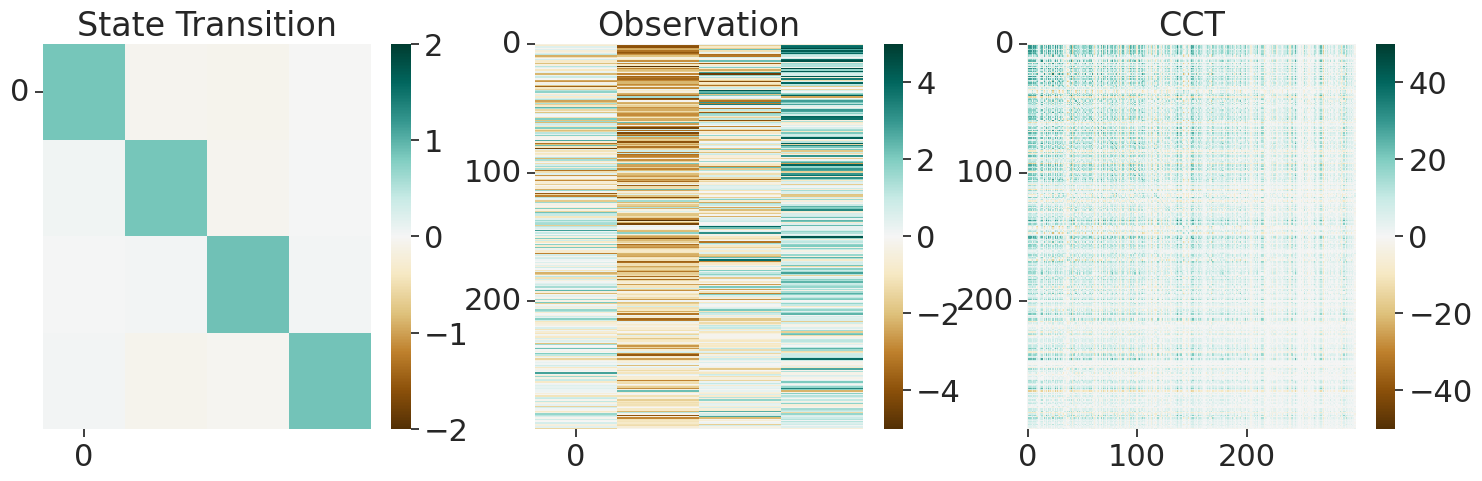

In [7]:
start_time = time.time()
A, C, Q, R, latents = fit_lds_em(x_list, d=4)
print("--- %s seconds ---" % (time.time() - start_time))


fig, ax = plt.subplots(1,3, figsize = (18,5))
CCT = C @ C.T
W_all = [A,C,CCT]
Mat_all  = ['State Transition', 'Observation','CCT']
vmin = [-2,-5,-50]
vmax = [2,5,50]

for i in range(3):
  ax[i] = sns.heatmap(W_all[i], vmin = vmin[i], vmax = vmax[i], ax = ax[i], cmap="BrBG",xticklabels = 100, yticklabels = 100)
  ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0)
  #ax[i].set_ylabel('variable')
  #ax[i].set_xlabel('variable')
  ax[i].set_title(Mat_all[i])
plt.show()


## Question 2

* Plot the the eigenvalues of the transition matrix.  What do these eigenvalues tell about the dynamics of neural activity

#######

As it is seen in the plot, all eigenvalues are clustered close to 1 on the real axis, with small or zero imaginary parts. They all are inside the unit circle, which means that the system is stable and that neural activity has bounded, decaying or steady dynamics. The dynamics are mainly non oscillatory, meaning that activity tends to evolve smoothly.
....

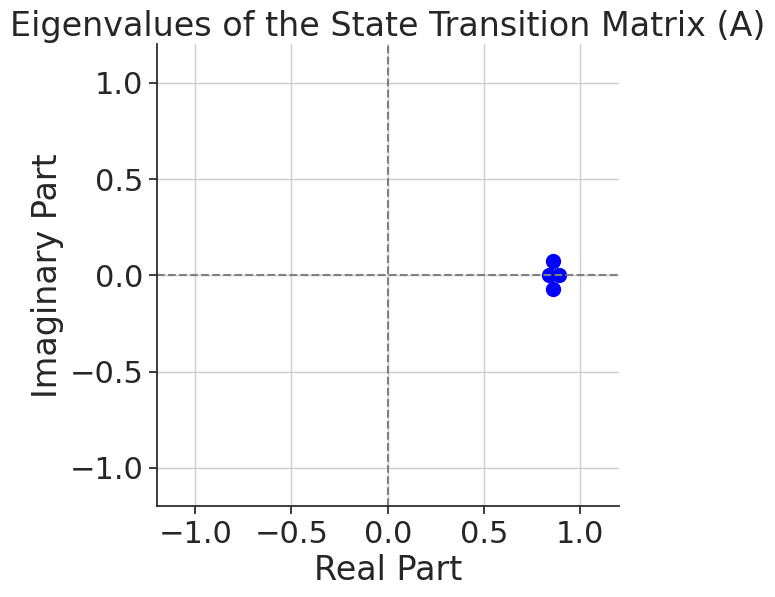

In [14]:
#### Plot eigenvalues ####

# Code goes here (you can use  np.linalg.eig )
eigenvalues, _ = np.linalg.eig(A)

plt.figure(figsize=(6,6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), color='blue', s=100)
plt.title('Eigenvalues of the State Transition Matrix (A)')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.gca().set_aspect('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.show()



##  Question 3

* Now you will use the function `plot_latents_by_stimulus` to plot each of the latent variables that were estimated, color-coded by the stimulus that was shown.
* Describe the dynamics of the latent traces. Is there some latent dynamics from which you can infer the stimulus?

#######

In Latent Dimension 1, there is a stimulus separation over time, which is a divergence especially in the early and middle time points. This suggests that Latent 1 is informative for distinguishing between stimuli.

In Latent Dimension 2, there is an obvious downward trend in all stimuli, although with some differences in slope and curvature. That is th reason why it is less separable than Dimension 1, but may carry some discriminative signal.

In Latent Dimension 3, there is some clustering by stimuli and some stimulus-specific offsets are visible:
- The blue curves starts high and decreases.
- The purple curves starts low and increases.
This suggests that dimension 3 could carry complementary stimulus information.

The last one, Latent Dimension 4 is more noisy and the trajectories overlap in many cases, so patterns are harder to distiguish and it is likely less informative for stimulus identify.


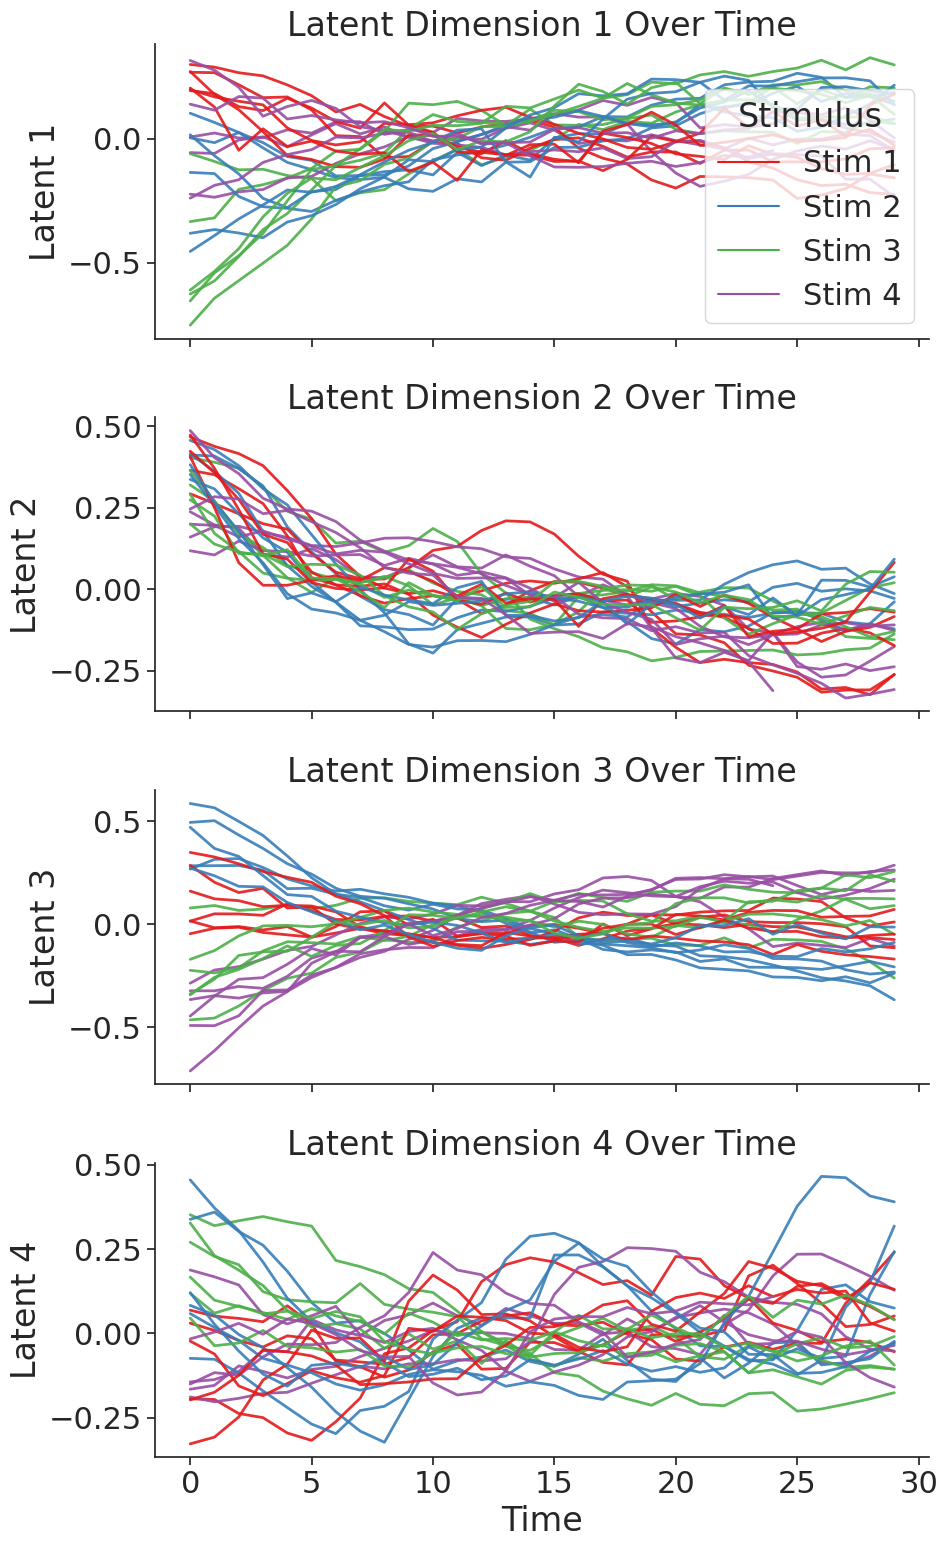

In [15]:
#### Plot the latent variables color code by time ####

# Code already provided

plot_latents_by_stimulus(latents, stimulus_labels)



##  Question 4.a

* Now you will create a function `decode_trial` to decode the orientation of the stimulus from the latent variables. Fish perform the required action within one second which correspond to 3 frames in imaging. Therefore, we will consider the first 3 points from the estimated latent and average them for decoding. Let us denote by $z_{i,j}$ the average of the  $i^{th}$ latent variable from trial $j$. And $y_j$ the stimulus that was shown during trial $j$ reprsented by a 2D vector: $[0, 1]$ for  0°, $[1, 0]$ for 90°, $[0, -1]$ for  180° and $[-1, 0]$ for -90°.

The goal is to find a linear transformation (matrix) $W = \{w_{i,j}\}$ that minimimizes:

\begin{align*}
   \min_{W} \sum\limits_{i}^{24} \sum\limits_{j}^{4} \lvert \lvert w_{i,j}z_{i,j} - y_j \rvert \rvert_2^2
\end{align*}

For this, you will use a regularized version that keeps the norm of $W$ bounded (ridge regression). In the code bellow, the matrices $Z$ and $Y$ are computed already. You only need to use the `ridge` function from `sklearn`sklearn to find the $2 \times $ weights matrix $W$.

In [16]:
#This cell runs ridge regression to find W that minimizes ||ZW - Y||_2^2

stim_to_vec = {
    1: np.array([0, 1]),     # 0°
    2: np.array([1, 0]),     # 90°
    3: np.array([0, -1]),    # 180°
    4: np.array([-1, 0])    # -90°
}



### The stimulus vector Y
Y = []
for s in stimulus_labels:
     Y.append(stim_to_vec[s])

Y = np.stack(Y)  # shape (n_trials, 2)


### The latent data vector Z

Z = []
frames_to_decode = 3

for z in latents:
    T = z.shape[0]
    post =z[:frames_to_decode,:]

    feat = post.mean(axis=0)


    Z.append(feat)

Z = np.stack(Z)  # shape (n_trials, d)


def decode_trial(Z, Y, ridge_alpha=.1):
    """
    Decode custom 2D stimulus vectors from post-stimulus summary of each trial.

    Args:
        latent vector: (trials, d) array
        stimulus vector (orientation): (2, d) arrays
        ridge_alpha: regularization strength

    Returns:
        decoder_coef: weight matrix (2 x d)
        mse: mean squared decoding error
    """




    # Fit decoder
    decoder = Ridge(alpha=ridge_alpha, fit_intercept=False)
    decoder.fit(Z, Y)
    Y_pred = decoder.predict(Z)

    mse = np.mean((Y_pred - Y) ** 2)



    return decoder.coef_, mse, Y_pred, Y



##  Question 4.b
* The cell below runs the `decode_trial` function on the data and plot the fiiting results as an error vector (estimated orientation - targeted orientation).
* What is your intrepretation of these results? Can a simple linear decoder guess the orientation of the stimulus?


#######

In the plot generated, each black dot represents the true stimulus direction, and each blue arrow is an error vector that starts at the true stimulus and ends at the decoded estimate. The length and direction of each arrow indicate the magnitude and direction of the decoding error.
In our case, the arrows are relatively short, so the decoder is generally making accurate predictions; errors are unbiased, as there is no strong systematic drift in one direction; and cluster separation is preserved, as we can see the vectors are clearly grouped by target direction, matching the true stimulus.

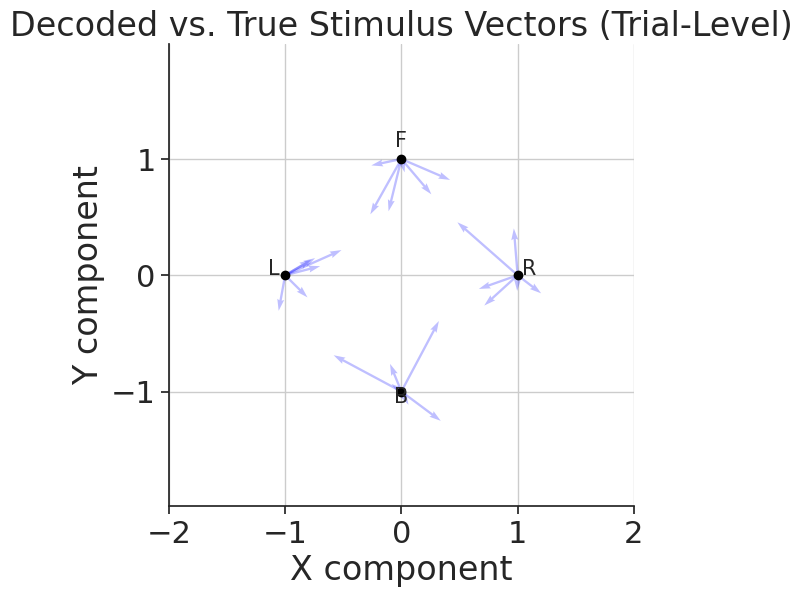

Mean squared error (trial-level decoding): 0.0802


In [17]:
#### This will run decode_trial on the inferred latent variables

W, mse,  Y_pred, Y = decode_trial(Z, Y)
#  plot
plt.figure(figsize=(6, 6))
      # Plot fixed reference directions
ref_vecs = np.array([
    [0, 1],    # 0°
    [1, 0],   # 90°
    [0, -1],    # 180°
    [-1, 0],  # -90°
])
ref_labels = ["F", "R", "B", "L"]
for vec, label in zip(ref_vecs, ref_labels):
    plt.plot(*vec, 'ko')
    plt.text(vec[0] * 1.1, vec[1] * 1.1, label, fontsize=15, ha='center')

plt.quiver(Y[:, 0], Y[:, 1], Y_pred[:, 0] - Y[:, 0] ,Y_pred[:, 1]-Y[:, 1]  ,
           angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.25, width=0.005)
plt.xlabel("X component")
plt.ylabel("Y component")
plt.title("Decoded vs. True Stimulus Vectors (Trial-Level)")
plt.axis("equal")
plt.grid(True)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

print(f"Mean squared error (trial-level decoding): {mse:.4f}")


##  Question 4.C

* Now, will make a function `latent_contributions` to evaluate the contribution of each latent dimension; how impprtant is each dimension for the decoding. A dimension with high importance will have a high l_2 norm. Fill the code below and plot these contributions.


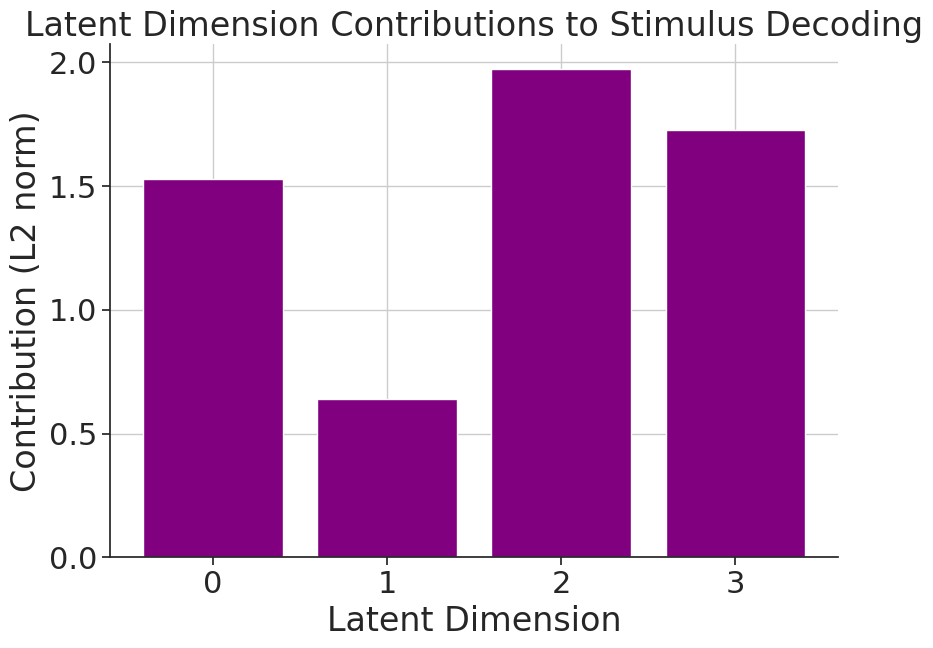

In [18]:
def latent_contributions(W):
    """
    Analyze how much each latent dimension contributes to decoding.

    Args:
        W: weight matrix (2 x d)

    Returns:
        importance: array of length d with L2 norm per latent
    """


    latent_importance = np.linalg.norm(W, axis=0)


    return latent_importance

importance = latent_contributions(W)
plt.figure(figsize=(9, 7))

plt.bar(np.arange(len(importance)), importance, color='purple')
plt.xlabel("Latent Dimension")
plt.ylabel("Contribution (L2 norm)")
plt.title("Latent Dimension Contributions to Stimulus Decoding")
plt.grid(True)
plt.tight_layout()
plt.show()

